## automating the regularization parameter tuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import wobble
import tensorflow as tf
from tqdm import tqdm

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starname = '51peg'
o = 0
data = wobble.Data(starname+'_e2ds.hdf5', filepath='data/', orders=[o], padding=3)
results = wobble.Results(data=data)

In [7]:
validation_epochs = np.random.choice(data.N, data.N//10, replace=False)
training_epochs = np.delete(np.arange(data.N), validation_epochs)
    
training_data = wobble.Data('51peg_e2ds.hdf5', filepath='data/', orders=[o], mask_epochs=validation_epochs)
training_results = wobble.Results(training_data)

validation_data = wobble.Data('51peg_e2ds.hdf5', filepath='data/', orders=[o], mask_epochs=training_epochs)
validation_results = wobble.Results(validation_data)

In [8]:
r = 0
training_model = wobble.Model(training_data, training_results, r)
training_model.add_star('star', variable_bases=0)
training_model.add_telluric('tellurics', rvs_fixed=True, variable_bases=0)
training_model.setup()

validation_model = wobble.Model(validation_data, validation_results, r)
validation_model.add_star('star', variable_bases=0)
validation_model.add_telluric('tellurics', rvs_fixed=True, variable_bases=0)
validation_model.setup()

0it [00:00, ?it/s]


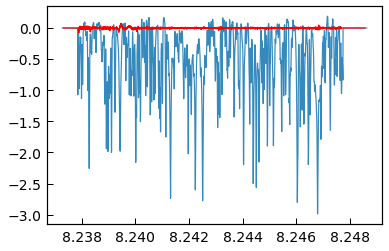

In [9]:
training_model.optimize(niter=0)
plt.plot(training_results.star_template_xs[0], training_results.star_template_ys[0])
plt.plot(training_results.tellurics_template_xs[0], training_results.tellurics_template_ys[0], c='r')

In [10]:
regularization_dict = {training_model.components[0].L1_template_tensor: 0.,
                      training_model.components[0].L2_template_tensor: 1.e-1,
                      training_model.components[1].L1_template_tensor: 0.,
                      training_model.components[1].L2_template_tensor: 1.e3,
                      training_model.components[1].L1_basis_vectors_tensor: 0.,
                      training_model.components[1].L2_basis_vectors_tensor: 0.,
                      training_model.components[1].L2_basis_weights_tensor: 1.0}

In [11]:
def test_regularization_value(par, value, training_model, validation_model, regularization_dict, 
                              plot=False):
    '''
    Try setting regularization parameter `par` to value `value`; return goodness metric `nll`.
    '''
    regularization_dict[par] = value
    training_model.optimize(niter=60, feed_dict=regularization_dict)
    validation_dict = {**regularization_dict}
    for c in validation_model.components:
        validation_dict[getattr(c, 'template_xs')] = getattr(training_model.results, 
                                                             c.name+'_template_xs')[training_model.r]
        validation_dict[getattr(c, 'template_ys')] = getattr(training_model.results, 
                                                             c.name+'_template_ys')[training_model.r]
        if c.K > 0:
            validation_dict[getattr(c, 'basis_vectors')] = getattr(training_model.results, 
                                                                   c.name+'_basis_vectors')[training_model.r]
    session = wobble.utils.get_session()
    for i in tqdm(range(60)):
        for c in validation_model.components:
            if not c.rvs_fixed:
                session.run(c.opt_rvs, feed_dict=validation_dict) # HACK
            if c.K > 0:
                session.run(c.opt_basis_weights, feed_dict=validation_dict)
                
    zero_regularization_dict = {**regularization_dict} # for final chi-sq eval
    for key in zero_regularization_dict:
        zero_regularization_dict[key] = 0.0
    for c in validation_model.components:
        zero_regularization_dict[getattr(c, 'template_xs')] = getattr(training_model.results, 
                                                             c.name+'_template_xs')[training_model.r]
        zero_regularization_dict[getattr(c, 'template_ys')] = getattr(training_model.results, 
                                                             c.name+'_template_ys')[training_model.r]
        if not c.rvs_fixed:
            zero_regularization_dict[getattr(c, 'rvs')] = getattr(validation_model.results, 
                                                             c.name+'_rvs')[training_model.r]
        if c.K > 0:
            zero_regularization_dict[getattr(c, 'basis_vectors')] = getattr(training_model.results, 
                                                                   c.name+'_basis_vectors')[training_model.r]
            zero_regularization_dict[getattr(c, 'basis_weights')] = getattr(validation_model.results, 
                                                                   c.name+'_basis_weights')[training_model.r]


    if plot:
        for c in validation_model.components:
            validation_model.results.update(c, feed_dict=validation_dict)
        n = validation_epochs[0]
        fig, ax = plt.subplots(1, 1, figsize=(12,5))
        ax.plot(np.exp(data.xs[r][n]), np.exp(data.ys[r][n]), color='k')
        ax.plot(np.exp(data.xs[r][n]), np.exp(validation_results.star_ys_predicted[r][n]), color='r', alpha=0.5)
        ax.plot(np.exp(data.xs[r][n]), np.exp(validation_results.tellurics_ys_predicted[r][n]), color='b', alpha=0.8)
        ax.set_ylim([0.0,1.3])
        # HACK:
        return session.run(validation_model.nll, feed_dict=zero_regularization_dict), training_results.tellurics_template_ys[r]
        
    return session.run(validation_model.nll, feed_dict=zero_regularization_dict)

#### try a grid of telluric template L2 values

100%|██████████| 60/60 [00:03<00:00, 19.90it/s]


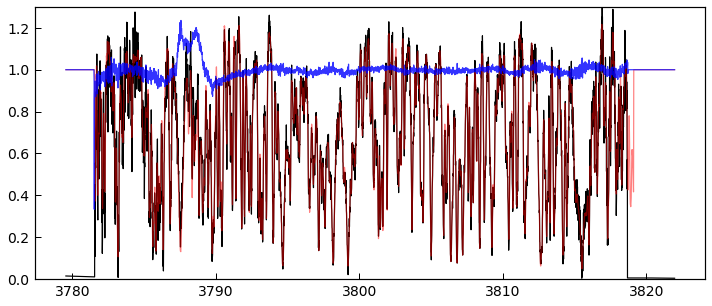

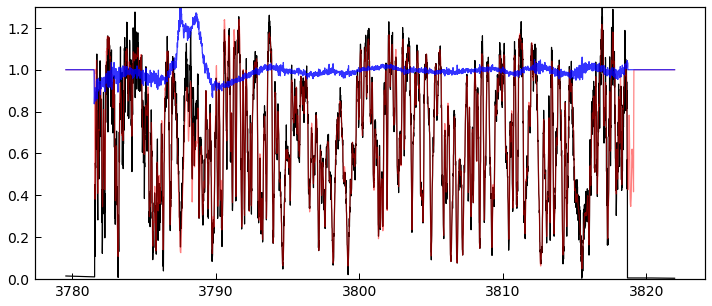

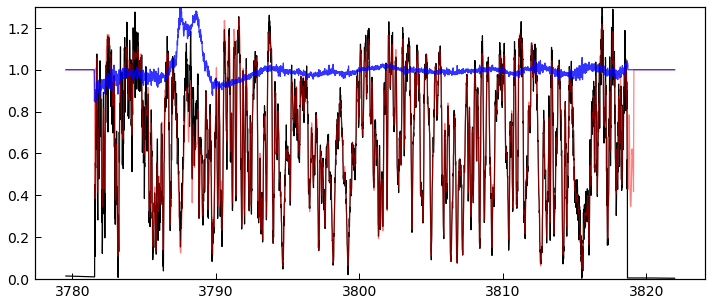

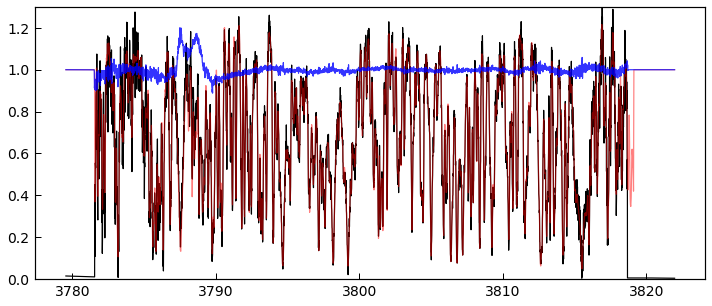

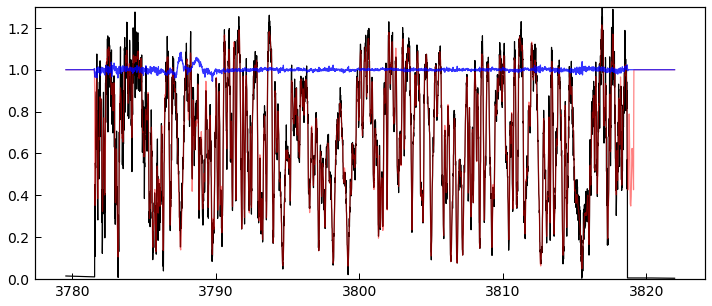

In [12]:
par = training_model.components[1].L2_template_tensor
current_value = np.copy(regularization_dict[par])
grid = np.logspace(-2.0, 2.0, num=5) * current_value
nll_grid = np.zeros_like(grid)
template_grid = [0 for n in range(len(grid))]
for i,val in enumerate(grid):
    nll_grid[i], template_grid[i] = test_regularization_value(par, val, training_model, validation_model, 
                                            regularization_dict, plot=True)

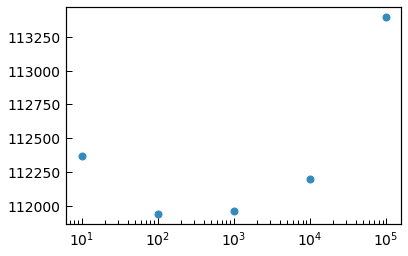

In [13]:
plt.scatter(grid, nll_grid)
plt.xscale('log')

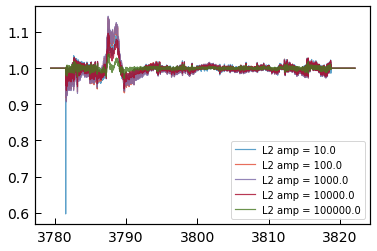

In [22]:
for v,t in zip(grid, template_grid):
    plt.plot(np.exp(training_results.tellurics_template_xs[0]), np.exp(t), 
             label="L2 amp = {0}".format(v),alpha = 0.8)
plt.legend()
plt.savefig('telluric_L2.png')

#### looking for weird features in the data:

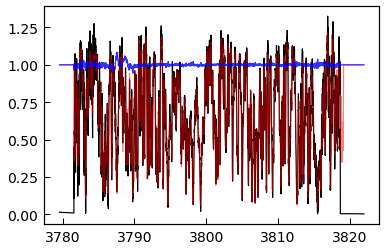

In [18]:
n = validation_epochs[0]
plt.plot(np.exp(data.xs[r][n]), np.exp(data.ys[r][n]), color='k')
plt.plot(np.exp(data.xs[r][n]), np.exp(validation_results.star_ys_predicted[r][n]), color='r', alpha=0.5)
plt.plot(np.exp(data.xs[r][n]), np.exp(validation_results.tellurics_ys_predicted[r][n]), color='b', alpha=0.8)

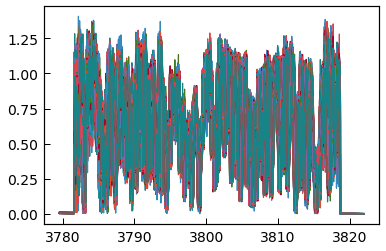

In [19]:
for n in range(data.N):
    plt.plot(np.exp(data.xs[0][n]), np.exp(data.ys[0][n]))


(3785, 3790)

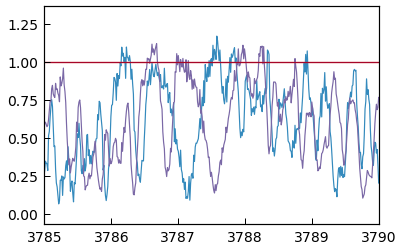

In [21]:
plt.plot(np.exp(data.xs[0][0]), np.exp(data.ys[0][0]))
plt.plot(np.exp(data.xs[0][0]), data.ivars[0][0] > 0)
plt.plot(np.exp(data.xs[0][70]), np.exp(data.ys[0][70]))
plt.plot(np.exp(data.xs[0][70]), data.ivars[0][70] > 0)
plt.xlim([3785,3790])

#### playing with ivars:

(3781.3, 3781.8)

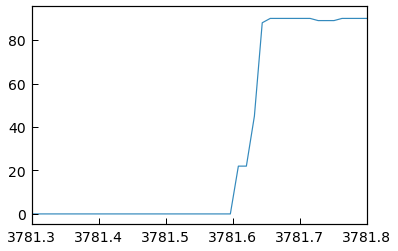

In [3]:
plt.plot(np.exp(data.xs[0][0]), np.sum(data.ivars[0] > 0., axis=0))
plt.xlim([3781.3,3781.8])


In [4]:
import h5py
with h5py.File(data.origin_file) as f: 
    ys = [f['data'][i] for i in [o]]

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


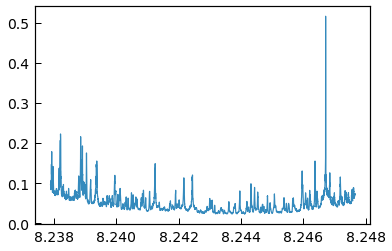

In [5]:
plt.plot(data.xs[0][0], 1./np.sqrt(ys[0][0]))

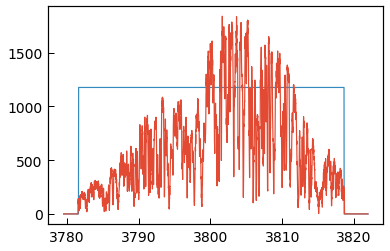

In [6]:
plt.plot(np.exp(data.xs[0][0]), data.ivars[0][0])
plt.plot(np.exp(data.xs[0][0]), ys[0][0])